In [1]:
wd <- dirname(dirname(getwd()))
source(paste0(wd,"/mission_control/treasure_map.R"))
source(paste0(wd,"/mission_control/helpers/figures/figure2_theme.R"))

library(tidyverse)
library(ggrepel)
library(RColorBrewer)
library(gridExtra)
library(ggpubr)

Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  3.1.2     ✔ purrr   0.3.4
✔ tidyr   1.1.3     ✔ dplyr   1.0.6
✔ readr   1.3.1     ✔ stringr 1.4.0
✔ tibble  3.1.2     ✔ forcats 0.5.1
Warning message:
“package ‘tibble’ was built under R version 3.6.3”Warning message:
“package ‘tidyr’ was built under R version 3.6.3”Warning message:
“package ‘purrr’ was built under R version 3.6.3”Warning message:
“package ‘dplyr’ was built under R version 3.6.3”Warning message:
“package ‘forcats’ was built under R version 3.6.3”── Conflicts ────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



##### Put in settings

In [2]:
ingredients <- readRDS(paste0(TMP_DIR,"exhaustive-plots-base.Rds"))
labels <- readRDS(paste0(TMP_DIR,"exhaustive-plots-labels.Rds"))
labels$size <- labels$size
threshold <- -log10(ingredients$by_05_fdr)[1]

Warning message:
“Unknown or uninitialised column: `size`.”

##### Plots

In [3]:
size_map <- list( "TRUE" = 4, "FALSE" = 2)
alpha_map <- list( "TRUE" = 1, "FALSE" = .4)
color_map <- list( "TRUE" = "black", "FALSE" = "white")
fill_map <- list("Clinical"="#9E7788",
                 "CNV/SVs"="#B3DE69",
                 "HLA"="#FFFF99",
                 "RNA: Remaining"= "#E0BA92", #"#FC913A",
                 "Somatic"="#80B1D3",
                 "RNA: T-cell" = "#FB8072",
                 "RNA: TGFB" = "#BEBADA", 
                 "RNA: Proliferation" = "#8DD3C7")

In [4]:
aes_main <- aes(x = plot_est, y = log10_p, fill = discovery_group, size = log10_p > threshold, alpha = log10_p > threshold, color = log10_p > threshold ) #+ guides_main

In [5]:
guides_main <- guides(alpha = "none", size = "none", color = "none", fill = guide_legend(override.aes = list(size=5)))

In [6]:
all <- ingredients %>% filter(dataset == "all")
latent <- all %>% filter(cor_pretreat > .8 | cor_tmb > .8 | cor_tcell > .8 | cor_prolif > .8 | cor_tgfb > .8)
non_latent <- all %>% filter( abs(cor_pretreat) < .3, abs(cor_tmb) < .3, abs(cor_tcell) < .3, cor_prolif < .3, cor_tgfb < .3)

In [7]:
max_y <- max(all %>% filter(covariates == "age_biopsy_purity_tissue") %>% pull(log10_p))

In [8]:
plots_go <- function( df = all, mod = "bor", cov = "age_biopsy_purity_tissue", xlab = "X", title = "X"){(
      ggplot(df %>% filter(covariates == cov, model == mod), aes_main) + 
        geom_point(shape = 21, stroke = 0.3) + 
        scale_y_continuous(breaks = c(seq(0,max_y,2)), limits = c(0,max_y)) + 
        scale_x_continuous(n.breaks = 3)  +
        scale_size_manual(values = unlist(size_map))  +
        scale_alpha_manual(values = unlist(alpha_map)) + 
        scale_color_manual(values = unlist(color_map) ) + 
        scale_fill_manual(values = unlist(fill_map), limits = force) + 
        geom_hline( yintercept = threshold, linetype="dashed", color = "black" ) + 
        xlab( xlab ) + 
        ylab("-Log10 p-value") +  
        ggtitle( title) +
        base_theme
    )
}

In [9]:
remove_y  <- theme(axis.text.y=element_blank(), axis.title.y=element_blank())

In [18]:
make_layer <- function( df = all, label = "All", overall_title = "X" ){
    p1 <- plots_go(df, mod = "bor", cov = "age_biopsy_purity_tissue", xlab = "Odds Ratio Estimate", title = paste0("BOR vs ", label))
    p2 <- plots_go(df, mod = "pfs", cov = "age_biopsy_purity_tissue",  xlab = "1/PFS Hazard Estimate", title = paste0("PFS vs ", label)) + remove_y
    p3 <- plots_go(df, mod = "os", cov = "age_biopsy_purity_tissue",  xlab = "1/OS Hazard Estimate", title = paste0("OS vs ", label)) + remove_y
    p4 <- plots_go(df %>% filter(cor_tmb < .3, cor_tcell < .3, cor_pretreat < .3), mod = "os", cov = "residuals", xlab = "1/OS Hazard Estimate", title = paste0("OS Residuals vs ", label)) + remove_y 
    legend <- get_legend(p3 + theme(legend.position = "right") + guides_main)
    as_ggplot(arrangeGrob(p1,p2,p3,p4, legend, layout_matrix = rbind(c(1,1,1,2,2,2,3,3,3,4,4,4,5,5)))) + theme(plot.title = element_text(size = 18, vjust = 0, hjust = .4)) + ggtitle(overall_title)
}

In [19]:
options(repr.plot.width = 14, repr.plot.height = 4.5)

In [20]:
annote <- function( i, lab ) annotate_figure( i, fig.lab = lab, fig.lab.size = 18, fig.lab.face = "bold")

In [21]:
all_go <- annote(make_layer(df = all, label = "All", overall_title = "All features"), "A")
latent_go <- annote(make_layer(df = latent, label = "Latent", overall_title = "Features with > .8 correlation to latent factors"), "B")
non_latent_go <- annote(make_layer(df = non_latent, label = "Non-latent", overall_title = "Features with < .3 correlation to latent factors"), "C")

In [22]:
options(repr.plot.width = 14, repr.plot.height = 14)

In [23]:
lets_go <- as_ggplot(arrangeGrob( all_go, latent_go, non_latent_go, ncol = 1)) + ggtitle("HMF CPI: Exhaustive Analysis by latent factor correlation groups")

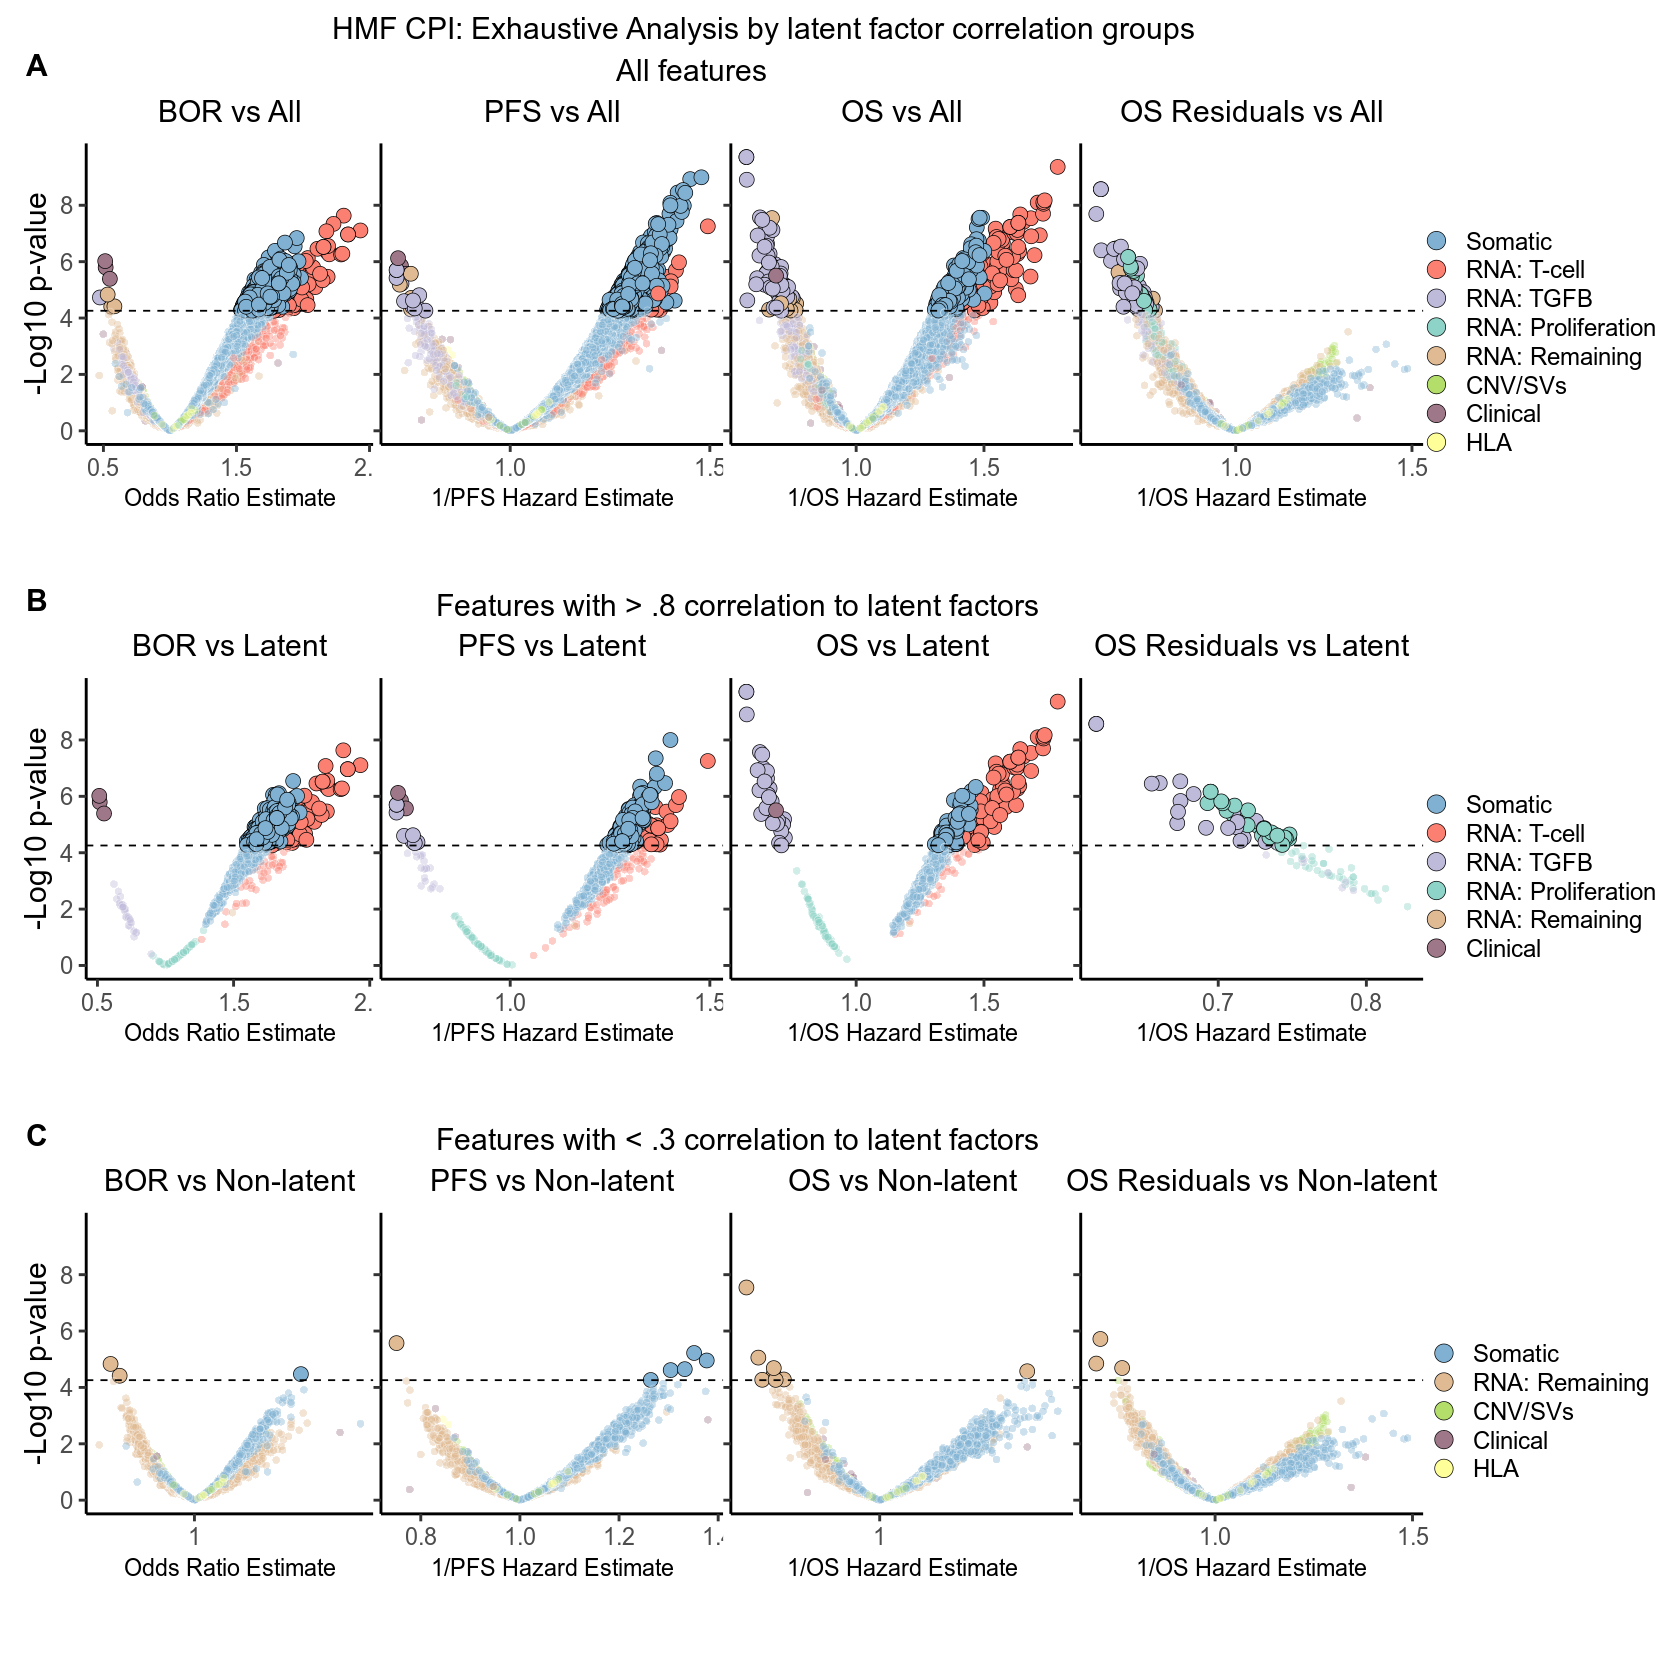

In [24]:
lets_go + theme(plot.margin = margin(.5,.5,.5,.5, "cm"), plot.title = element_text(vjust = 2, hjust = .4, size = 18))

In [25]:
ggsave(file = paste0(FIG_FINAL_DIR, "7b_supplement_note_exhaustive_latent_go.png"), width =14, height = 14)